# Import Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import stdev

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import L1L2

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import datetime
import math
import pickle

# Define Functions

In [2]:
def Average(data):
    return sum(data) / len(data)

def convert_bit_lenght(data):        
    a = []
    for element in data:
        native_int = int(element)
        a.append(native_int.bit_length())
    return a

def normalize_series(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    scaled_data = (data - mean) / std
    return scaled_data

def inverse_normalize_series(scaled, original):
    # Mean and standard deviation of the original data
    mean = np.mean(original, axis=0)
    std = np.std(original, axis=0)

    # Inverse Z-score scaling
    original_data = scaled * std + mean
    original_data = np.round(original_data,0)
    return original_data

def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

# Read Dataset

In [3]:
data = pd.read_excel('ready_data_pax_bms 1 April - 19 Juli 2023.xlsx', index_col='Unnamed: 0')
data

DATE  PAX_BMS_T1  PAX_BMS_T2  PAX_BMS_T3
0    2023-04-01 00:00:00           0           8           0
1    2023-04-01 01:00:00           0           0           0
2    2023-04-01 02:00:00           0           0           0
3    2023-04-01 03:00:00           0           0           0
4    2023-04-01 04:00:00           0           0           0
...                  ...         ...         ...         ...
2635 2023-07-19 19:00:00          73         119          65
2636 2023-07-19 20:00:00          69          92          90
2637 2023-07-19 21:00:00          28          25          47
2638 2023-07-19 22:00:00           2           9          31
2639 2023-07-19 23:00:00           1           3           4

[2640 rows x 4 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2640 entries, 0 to 2639
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        2640 non-null   datetime64[ns]
 1   PAX_BMS_T1  2640 non-null   int64         
 2   PAX_BMS_T2  2640 non-null   int64         
 3   PAX_BMS_T3  2640 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 103.1 KB


In [5]:
data.describe()

DATE   PAX_BMS_T1   PAX_BMS_T2   PAX_BMS_T3
count                 2640  2640.000000  2640.000000  2640.000000
mean   2023-05-25 23:30:00    36.214773    75.382197    57.459470
min    2023-04-01 00:00:00     0.000000     0.000000     0.000000
25%    2023-04-28 11:45:00     0.000000     4.750000     2.000000
50%    2023-05-25 23:30:00    27.000000    69.000000    57.000000
75%    2023-06-22 11:15:00    65.000000   127.000000    96.000000
max    2023-07-19 23:00:00   194.000000   394.000000   227.000000
std                    NaN    36.695872    69.154799    50.794938

# Split data to training, validation and testing

split data with proportion 65% for training data, 30% for validation data and 5% for testing

In [6]:
n_lookback = 24  # length of input sequences (lookback period)
n_forecast = 24  # length of output sequences (forecast period)

In [7]:
SPLIT_TIME_TRAIN_REM = int(math.floor(0.65*((len(data))/24)) * 24) 
print(f'jumlah data training: {SPLIT_TIME_TRAIN_REM}')

jumlah data training: 1704


In [8]:
data_train = data[:SPLIT_TIME_TRAIN_REM].loc[:, data.columns!='DATE']
data_train = pd.DataFrame(data_train)
data_train.index = data[:SPLIT_TIME_TRAIN_REM]['DATE']

data_rem = data[SPLIT_TIME_TRAIN_REM:].loc[:, data.columns!='DATE']
data_rem = pd.DataFrame(data_rem)
data_rem.index = data[SPLIT_TIME_TRAIN_REM:]['DATE']

In [9]:
SPLIT_TIME_VAL_TEST = int(math.floor(0.87*((len(data_rem))/24)) * 24) 
SPLIT_TIME_VAL_TEST
print(f'jumlah data validation: {SPLIT_TIME_VAL_TEST}')
print(f'jumlah data validation: {len(data_rem) - SPLIT_TIME_VAL_TEST}')

jumlah data validation: 792
jumlah data validation: 144


In [10]:
data_val = data_rem[:SPLIT_TIME_VAL_TEST]
data_val = pd.DataFrame(data_val)

data_test = data_rem[SPLIT_TIME_VAL_TEST:]
data_test = pd.DataFrame(data_test)

In [11]:
# % of training set
print(f'data training -> {(len(data_train)/len(data)) * 100}%')
print(f'data validation -> {(len(data_val)/len(data)) * 100}%')
print(f'data testing -> {(len(data_test)/len(data)) * 100}%')

data training -> 64.54545454545455%
data validation -> 30.0%
data testing -> 5.454545454545454%


In [12]:
data_train

PAX_BMS_T1  PAX_BMS_T2  PAX_BMS_T3
DATE                                                   
2023-04-01 00:00:00           0           8           0
2023-04-01 01:00:00           0           0           0
2023-04-01 02:00:00           0           0           0
2023-04-01 03:00:00           0           0           0
2023-04-01 04:00:00           0           0           0
...                         ...         ...         ...
2023-06-10 19:00:00          68         107          78
2023-06-10 20:00:00          22          68          76
2023-06-10 21:00:00          27          62          19
2023-06-10 22:00:00           5           6          28
2023-06-10 23:00:00           0           3           4

[1704 rows x 3 columns]

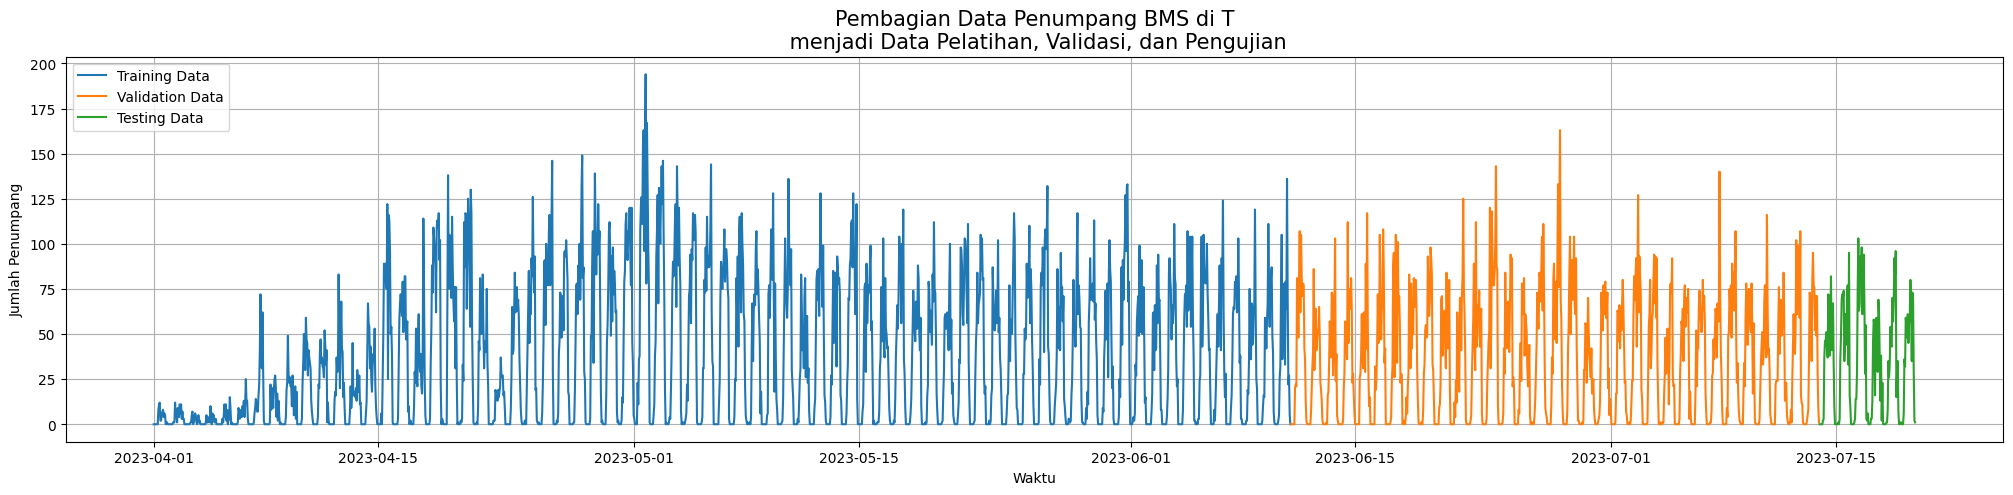

In [13]:
plt.subplots(figsize=(25, 5))
sns.lineplot(x="DATE", y="PAX_BMS_T1",
             data=data_train, label='Training Data')
sns.lineplot(x="DATE", y="PAX_BMS_T1",
             data=data_val, label='Validation Data')
sns.lineplot(x="DATE", y="PAX_BMS_T1",
             data=data_test, label='Testing Data')
plt.xlabel('Waktu'); plt.ylabel('Jumlah Penumpang')
plt.title("Pembagian Data Penumpang BMS di T\n menjadi Data Pelatihan, Validasi, dan Pengujian", fontsize = 15)
plt.grid()
plt.legend(loc='upper left')

## check sequence data

In [14]:
# paxBMS = data.values.reshape(-1, 1)

# paxBMS_train = data_train.values.reshape(-1, 1)
# paxBMS_val = data_val.values.reshape(-1, 1)
# paxBMS_test = data_test.values.reshape(-1, 1)

# print(paxBMS_train.shape);print(paxBMS_val.shape)

In [15]:
paxBMS = data.values

paxBMS_train = data_train.values
paxBMS_val = data_val.values
paxBMS_test = data_test.values

print(paxBMS_train.shape);print(paxBMS_val.shape)

(1704, 3)
(792, 3)


In [16]:
x_train = []
y_train = []

for i in range(n_lookback, len(paxBMS_train) - n_forecast + 1):
    x_train.append(paxBMS_train[i - n_lookback: i])
    y_train.append(paxBMS_train[i: i + n_forecast])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1657, 24, 3)
(1657, 24, 3)


In [17]:
print(x_train[0]);print(y_train[0])

[[  0   8   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   2   0]
 [  0   1  11]
 [  8  30  53]
 [ 11  51  51]
 [ 12  70  81]
 [  2  46  61]
 [  2  22  93]
 [  5  34  59]
 [  7  41 104]
 [  8  89  83]
 [  4 105 128]
 [  6  33  83]
 [  5  56  77]
 [  0  17  41]
 [  1  62  48]
 [  1  25  29]
 [  0  12  26]
 [  0   0   8]
 [  0   0   0]]
[[  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  1   4   1]
 [  1  14   6]
 [  1  15  47]
 [ 12  43  47]
 [  5  93  45]
 [  5  70  72]
 [  1  28  78]
 [  9  33  51]
 [  6  46  78]
 [  4  71 107]
 [ 11  40 152]
 [  6  50  80]
 [ 11  78  65]
 [  3  33  32]
 [  7  23  26]
 [  3  20  33]
 [  3  10   9]
 [  0   7   5]
 [  0   0   1]]


In [18]:
x_val = []
y_val = []

for i in range(n_lookback, len(paxBMS_val) - n_forecast + 1):
    x_val.append(paxBMS_val[i - n_lookback: i])
    y_val.append(paxBMS_val[i: i + n_forecast])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(745, 24, 3)
(745, 24, 3)


In [19]:
print(x_val[-1]);print(y_val[-1])

[[  2   0   6]
 [  0   7   0]
 [  0   0   0]
 [  0   0   0]
 [  2   0   0]
 [  8   5   2]
 [  1   7   2]
 [ 24  29  27]
 [ 43  65  55]
 [ 61 103  70]
 [ 45 132 115]
 [ 39  48  75]
 [ 54 104 125]
 [102 110 166]
 [ 61  65 105]
 [ 99 164 111]
 [ 67 122 103]
 [ 82 201 122]
 [ 59  95 114]
 [107 113 106]
 [ 16 130  67]
 [ 12  50  74]
 [ 11  22  12]
 [  1   3   9]]
[[  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   1   1]
 [  2   5   4]
 [  5  17   4]
 [  8  18  27]
 [ 34  88  41]
 [ 73 103  71]
 [ 71  90  73]
 [ 61 100 121]
 [ 35  94  99]
 [ 80 107 101]
 [ 95  80  93]
 [ 77 143 154]
 [ 76 154  83]
 [ 52 129 143]
 [ 71 156 102]
 [ 49 137 118]
 [ 71 149 148]
 [ 28 102  96]
 [  9  19  39]
 [  1   0  11]]


# Scaling / Normalize Data

In [20]:
np.std(paxBMS_train)

59.97935675620465

In [21]:
paxBMS_train

array([[ 0,  8,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       ...,
       [27, 62, 19],
       [ 5,  6, 28],
       [ 0,  3,  4]], dtype=int64)

In [22]:
scaled = normalize_series(paxBMS_train)
scaled

array([[-0.94141332, -0.97152489, -1.10934015],
       [-0.94141332, -1.07850249, -1.10934015],
       [-0.94141332, -1.07850249, -1.10934015],
       ...,
       [-0.24470053, -0.24942607, -0.74520611],
       [-0.81239244, -0.99826929, -0.57272157],
       [-0.94141332, -1.03838589, -1.03268036]])

In [23]:
original = inverse_normalize_series(scaled, paxBMS_train)
original

array([[ 0.,  8.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       ...,
       [27., 62., 19.],
       [ 5.,  6., 28.],
       [ 0.,  3.,  4.]])

In [24]:
paxBMS_train_scaled = normalize_series(paxBMS_train)

paxBMS_val_scaled = normalize_series(paxBMS_val)

paxBMS_test_scaled = normalize_series(paxBMS_test)

## Set feature and label period

In [25]:
x_train = []
y_train = []

for i in range(n_lookback, len(paxBMS_train_scaled) - n_forecast + 1):
    x_train.append(paxBMS_train_scaled[i - n_lookback: i])
    y_train.append(paxBMS_train_scaled[i: i + n_forecast])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1657, 24, 3)
(1657, 24, 3)


In [26]:
x_val = []
y_val = []

for i in range(n_lookback, len(paxBMS_val_scaled) - n_forecast + 1):
    x_val.append(paxBMS_val_scaled[i - n_lookback: i])
    y_val.append(paxBMS_val_scaled[i: i + n_forecast])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(745, 24, 3)
(745, 24, 3)


In [27]:
y_train[0].shape

(24, 3)

# Vanilla LSTM

## generate model

In [28]:
modelVanillaLSTM = Sequential([
        LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', return_sequences=True,
            input_shape=x_train[0].shape),                                          
        Flatten(),
        Dense(n_forecast * 3),
        Reshape([n_forecast, 3])
    ])

modelVanillaLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            17408     
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 72)                110664    
                                                                 
 reshape (Reshape)           (None, 24, 3)             0         
                                                                 
Total params: 128,072
Trainable params: 128,072
Non-trainable params: 0
_________________________________________________________________


In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
modelVanillaLSTM.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

In [30]:
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=15,verbose=1,
                                       restore_best_weights=True)
mc=tf.keras.callbacks.ModelCheckpoint('./model v3/VanillaLSTM-ModelAll.h5', monitor='val_mse', mode='min', verbose=1, save_best_only=True)

In [31]:
historyVanillaLSTM = modelVanillaLSTM.fit(
    x_train, y_train, 
    epochs=1000, 
    batch_size=32, 
    callbacks=[estop, mc],
    validation_data=(x_val,y_val))

Epoch 1/1000
48/52 [==========================>...] - ETA: 0s - loss: 1.7865 - mse: 1.0097
Epoch 1: val_mse improved from inf to 0.99015, saving model to ./model v3\VanillaLSTM-ModelAll.h5
52/52 [==============================] - 2s 14ms/step - loss: 1.7870 - mse: 1.0124 - val_loss: 1.7790 - val_mse: 0.9901
Epoch 2/1000
47/52 [==========================>...] - ETA: 0s - loss: 1.7674 - mse: 0.9869
Epoch 2: val_mse improved from 0.99015 to 0.96713, saving model to ./model v3\VanillaLSTM-ModelAll.h5
52/52 [==============================] - 0s 9ms/step - loss: 1.7677 - mse: 0.9893 - val_loss: 1.7597 - val_mse: 0.9671
Epoch 3/1000
47/52 [==========================>...] - ETA: 0s - loss: 1.7490 - mse: 0.9655
Epoch 3: val_mse improved from 0.96713 to 0.94400, saving model to ./model v3\VanillaLSTM-ModelAll.h5
52/52 [==============================] - 0s 9ms/step - loss: 1.7485 - mse: 0.9663 - val_loss: 1.7404 - val_mse: 0.9440
Epoch 4/1000
48/52 [==========================>...] - ETA: 0s - los

In [32]:
with open('./model v3/historyVanillaLSTM', 'wb') as file_pi:
    pickle.dump(historyVanillaLSTM.history, file_pi)

with open('./model v3/historyVanillaLSTM', "rb") as file_pi:
    load_historyVanillaLSTM = pickle.load(file_pi)

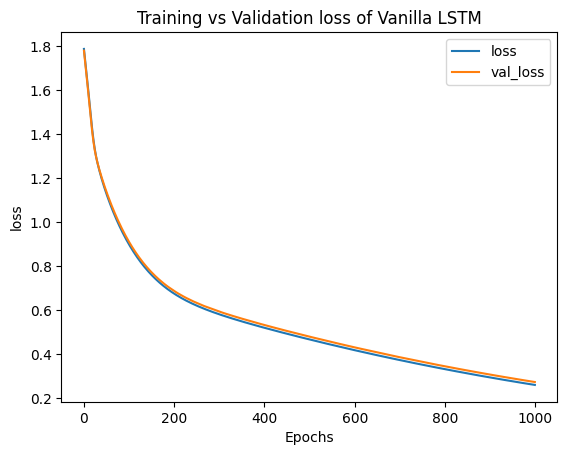

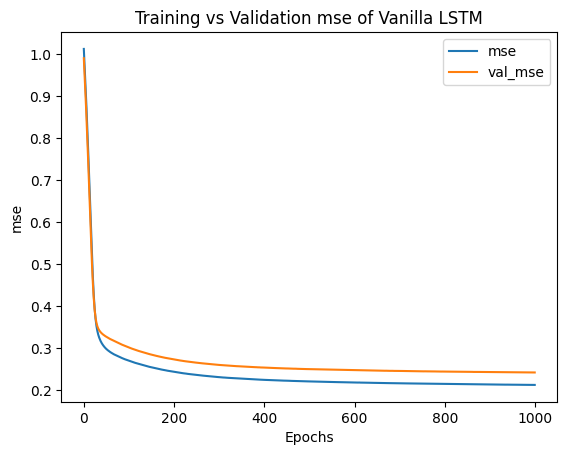

In [33]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric} of Vanilla LSTM")
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyVanillaLSTM, "loss")
plot_graphs(historyVanillaLSTM, "mse")

## Prediction

### Prediction with training data

In [34]:
forecast_train_data = model_forecast(modelVanillaLSTM, paxBMS_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(paxBMS_train_scaled.shape[0]-n_lookback)
forecast_train_data

1681/1681 [==============================] - 6s 4ms/step
(1681, 24, 3)
(1680, 3)
1680


array([[-1.0509079 , -1.1381109 , -1.171156  ],
       [-1.0633177 , -1.1812979 , -1.1528541 ],
       [-1.0569134 , -1.157399  , -1.0757178 ],
       ...,
       [-0.20944656,  0.09810569,  0.08742046],
       [-0.74067956, -0.6993491 , -0.65259176],
       [-0.97366476, -0.9923082 , -1.0266628 ]], dtype=float32)

In [35]:
paxBMS_train[24:]

array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       ...,
       [27, 62, 19],
       [ 5,  6, 28],
       [ 0,  3,  4]], dtype=int64)

In [36]:
original = inverse_normalize_series(forecast_train_data, paxBMS_train)
original

array([[-4., -4., -3.],
       [-5., -8., -2.],
       [-4., -6.,  2.],
       ...,
       [28., 88., 62.],
       [ 8., 28., 24.],
       [-1.,  6.,  4.]])

In [37]:
actual = np.squeeze(paxBMS_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1680, 3)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [38]:
corrected_forecast = []
for i in original:
    temp = []
    for j in i:
        if j < 0:
            temp.append(0)
        elif j >= 0:
            _temp = np.ceil(j)
            temp.append(int(_temp))        
    corrected_forecast.append(temp)


corrected_forecast = np.array(corrected_forecast)
print(len(corrected_forecast))
corrected_forecast

1680


array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  2],
       ...,
       [28, 88, 62],
       [ 8, 28, 24],
       [ 0,  6,  4]])

In [39]:
df_train = pd.DataFrame()
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index

df_train['Actual_T1'] = actual[:,0]
df_train['Actual_T2'] = actual[:,1]
df_train['Actual_T3'] = actual[:,2]

df_train['Forecast_T1'] = corrected_forecast[:,0]
df_train['Forecast_T2'] = corrected_forecast[:,1]
df_train['Forecast_T3'] = corrected_forecast[:,2]

df_train

Date  Actual_T1  Actual_T2  Actual_T3  Forecast_T1   
0    2023-04-02 00:00:00          0          0          0            0  \
1    2023-04-02 01:00:00          0          0          0            0   
2    2023-04-02 02:00:00          0          0          0            0   
3    2023-04-02 03:00:00          0          0          0            0   
4    2023-04-02 04:00:00          0          0          0            0   
...                  ...        ...        ...        ...          ...   
1675 2023-06-10 19:00:00         68        107         78           66   
1676 2023-06-10 20:00:00         22         68         76           49   
1677 2023-06-10 21:00:00         27         62         19           28   
1678 2023-06-10 22:00:00          5          6         28            8   
1679 2023-06-10 23:00:00          0          3          4            0   

      Forecast_T2  Forecast_T3  
0               0            0  
1               0            0  
2               0            2  
3               0            5  
4               3            8  
...           ...          ...  
1675          160           99  
1676          133           90  
1677           88           62  
1678           28           24  
1679            6            4  

[1680 rows x 7 columns]

### Visualisasi Training Data

#### Visualisasi T1

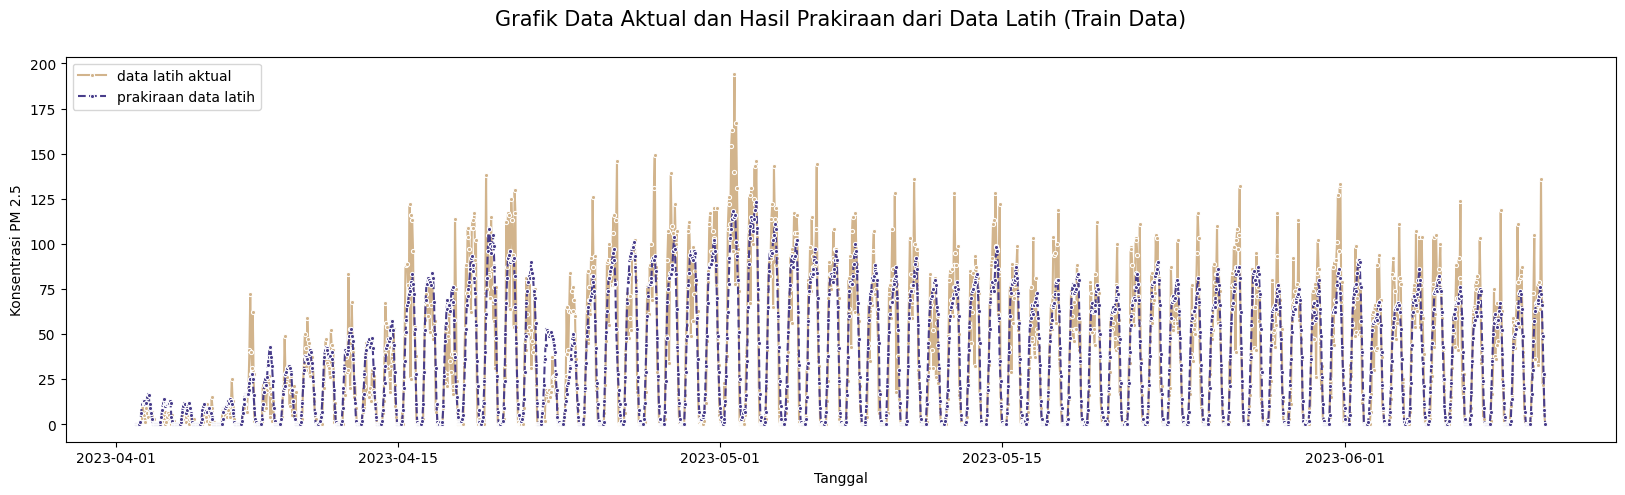

In [40]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T1", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T1", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [41]:
rmse = mean_squared_error(df_train['Forecast_T1'], df_train['Actual_T1'], squared=False)
mae = mean_absolute_error(df_train['Forecast_T1'], df_train['Actual_T1'])
mape = mean_absolute_percentage_error(df_train['Forecast_T1'], df_train['Actual_T1'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast Train accuracy
RMSE:  17.21
MAE:  11.05


#### Visualisasi T2

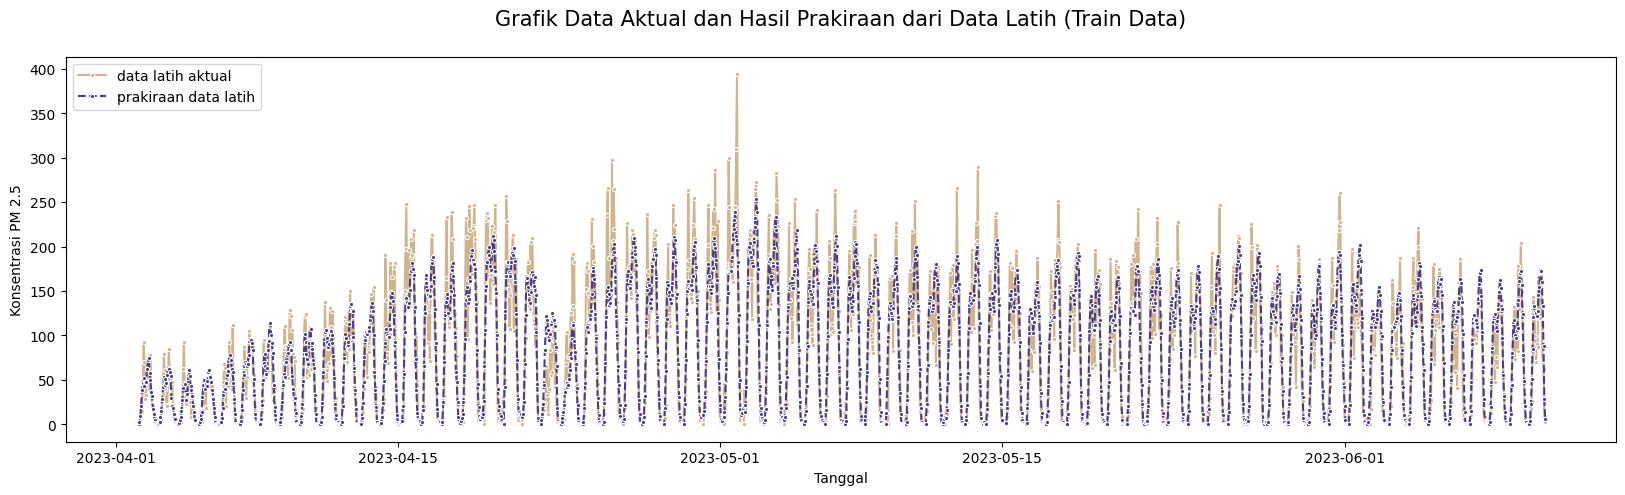

In [42]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T2", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T2", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [43]:
rmse = mean_squared_error(df_train['Forecast_T2'], df_train['Actual_T2'], squared=False)
mae = mean_absolute_error(df_train['Forecast_T2'], df_train['Actual_T2'])
mape = mean_absolute_percentage_error(df_train['Forecast_T2'], df_train['Actual_T2'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast Train accuracy
RMSE:  28.75
MAE:  19.5


#### Visualisasi T3

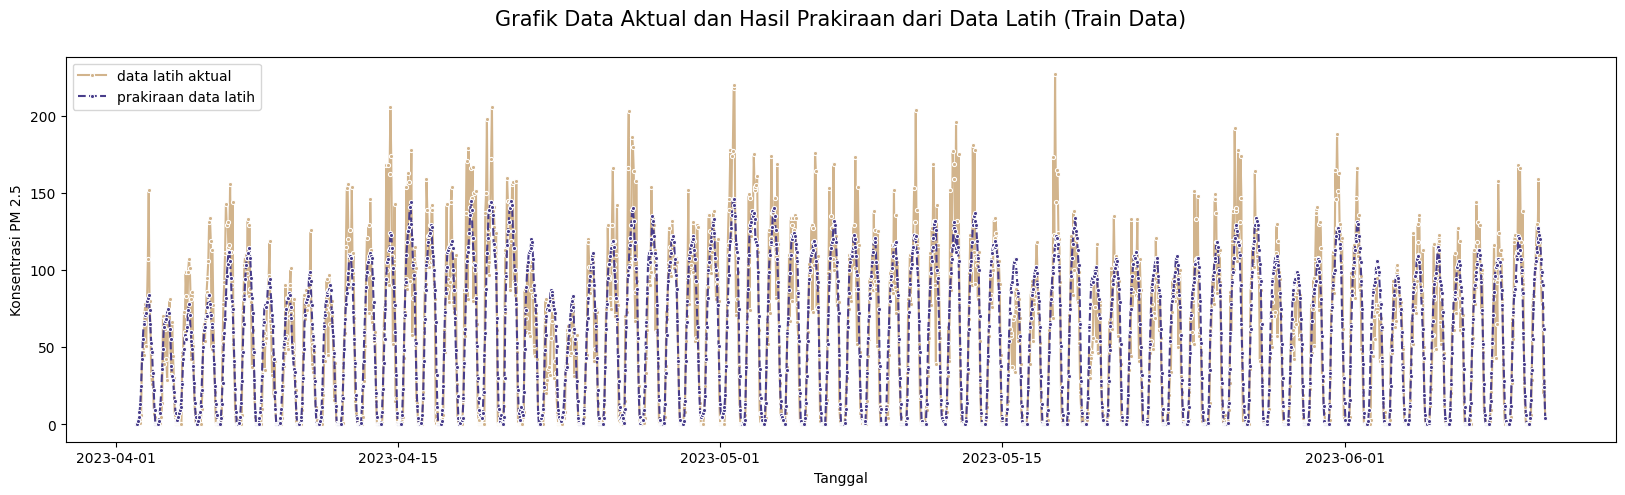

In [44]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T3", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T3", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [45]:
rmse = mean_squared_error(df_train['Forecast_T3'], df_train['Actual_T3'], squared=False)
mae = mean_absolute_error(df_train['Forecast_T3'], df_train['Actual_T3'])
mape = mean_absolute_percentage_error(df_train['Forecast_T3'], df_train['Actual_T3'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast Train accuracy
RMSE:  22.64
MAE:  15.43


### Prediction with validation data

In [46]:
forecast_val_data = model_forecast(modelVanillaLSTM, paxBMS_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(paxBMS_val_scaled.shape[0]-n_lookback)
forecast_val_data

769/769 [==============================] - 2s 3ms/step
(769, 24, 3)
(768, 3)
768


array([[-1.1050875 , -1.2042629 , -1.1674109 ],
       [-1.1393665 , -1.2724794 , -1.2732517 ],
       [-1.0998275 , -1.2667792 , -1.2812356 ],
       ...,
       [-0.120649  ,  0.06643913,  0.18006991],
       [-0.40251574, -0.38581544, -0.28455725],
       [-0.7747644 , -0.79576665, -0.7212051 ]], dtype=float32)

In [47]:
paxBMS_val[24:]

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       ...,
       [ 28, 102,  96],
       [  9,  19,  39],
       [  1,   0,  11]], dtype=int64)

In [48]:
original = inverse_normalize_series(forecast_val_data, paxBMS_val)
original

array([[-0., -2.,  0.],
       [-2., -6., -5.],
       [-0., -5., -5.],
       ...,
       [32., 71., 65.],
       [23., 45., 43.],
       [11., 22., 22.]])

In [49]:
actual = np.squeeze(paxBMS_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(768, 3)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [50]:
corrected_forecast = []
for i in original:
    temp = []
    for j in i:
        if j < 0:
            temp.append(0)
        elif j >= 0:
            _temp = np.ceil(j)
            temp.append(int(_temp))        
    corrected_forecast.append(temp)


corrected_forecast = np.array(corrected_forecast)
print(len(corrected_forecast))
corrected_forecast

768


array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       ...,
       [32, 71, 65],
       [23, 45, 43],
       [11, 22, 22]])

In [51]:
df_val = pd.DataFrame()
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index

df_val['Actual_T1'] = actual[:,0]
df_val['Actual_T2'] = actual[:,1]
df_val['Actual_T3'] = actual[:,2]

df_val['Forecast_T1'] = corrected_forecast[:,0]
df_val['Forecast_T2'] = corrected_forecast[:,1]
df_val['Forecast_T3'] = corrected_forecast[:,2]

df_val

Date  Actual_T1  Actual_T2  Actual_T3  Forecast_T1   
0   2023-06-12 00:00:00          0          0          0            0  \
1   2023-06-12 01:00:00          0          0          0            0   
2   2023-06-12 02:00:00          0          0          0            0   
3   2023-06-12 03:00:00          0          0          0            1   
4   2023-06-12 04:00:00          0          0          0            3   
..                  ...        ...        ...        ...          ...   
763 2023-07-13 19:00:00         49        137        118           63   
764 2023-07-13 20:00:00         71        149        148           46   
765 2023-07-13 21:00:00         28        102         96           32   
766 2023-07-13 22:00:00          9         19         39           23   
767 2023-07-13 23:00:00          1          0         11           11   

     Forecast_T2  Forecast_T3  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              2            0  
..           ...          ...  
763          132           94  
764          101           82  
765           71           65  
766           45           43  
767           22           22  

[768 rows x 7 columns]

### Visualisasi validation data

#### Visualisasi T1

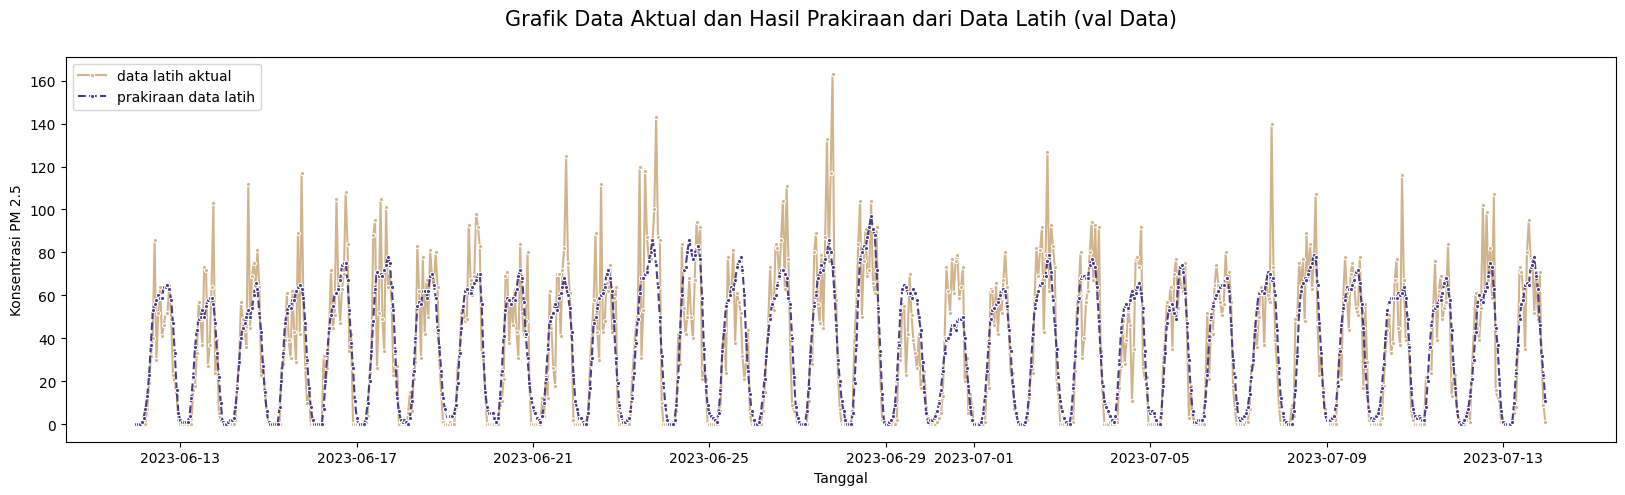

In [52]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T1", data=df_val, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T1", data=df_val, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (val Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [53]:
rmse = mean_squared_error(df_val['Forecast_T1'], df_val['Actual_T1'], squared=False)
mae = mean_absolute_error(df_val['Forecast_T1'], df_val['Actual_T1'])
mape = mean_absolute_percentage_error(df_val['Forecast_T1'], df_val['Actual_T1'])

print('Forecast val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast val accuracy
RMSE:  16.77
MAE:  11.75


#### Visualisasi T2

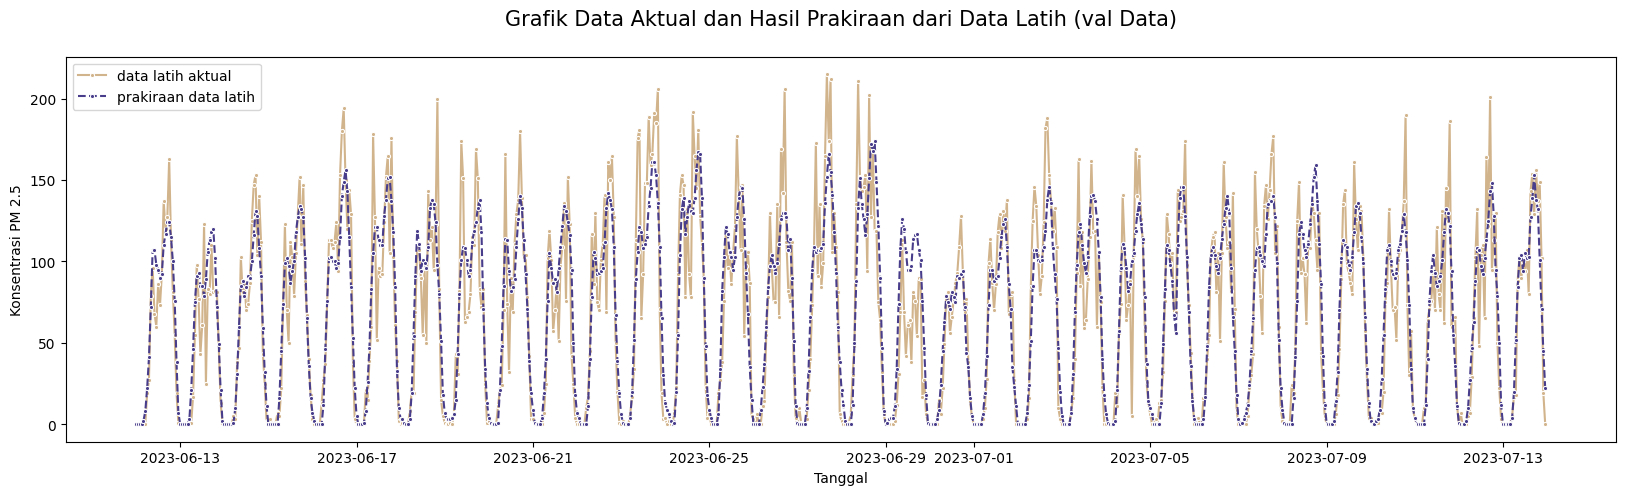

In [54]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T2", data=df_val, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T2", data=df_val, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (val Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [55]:
rmse = mean_squared_error(df_val['Forecast_T2'], df_val['Actual_T2'], squared=False)
mae = mean_absolute_error(df_val['Forecast_T2'], df_val['Actual_T2'])
mape = mean_absolute_percentage_error(df_val['Forecast_T2'], df_val['Actual_T2'])

print('Forecast val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast val accuracy
RMSE:  24.43
MAE:  17.05


#### Visualisasi T3

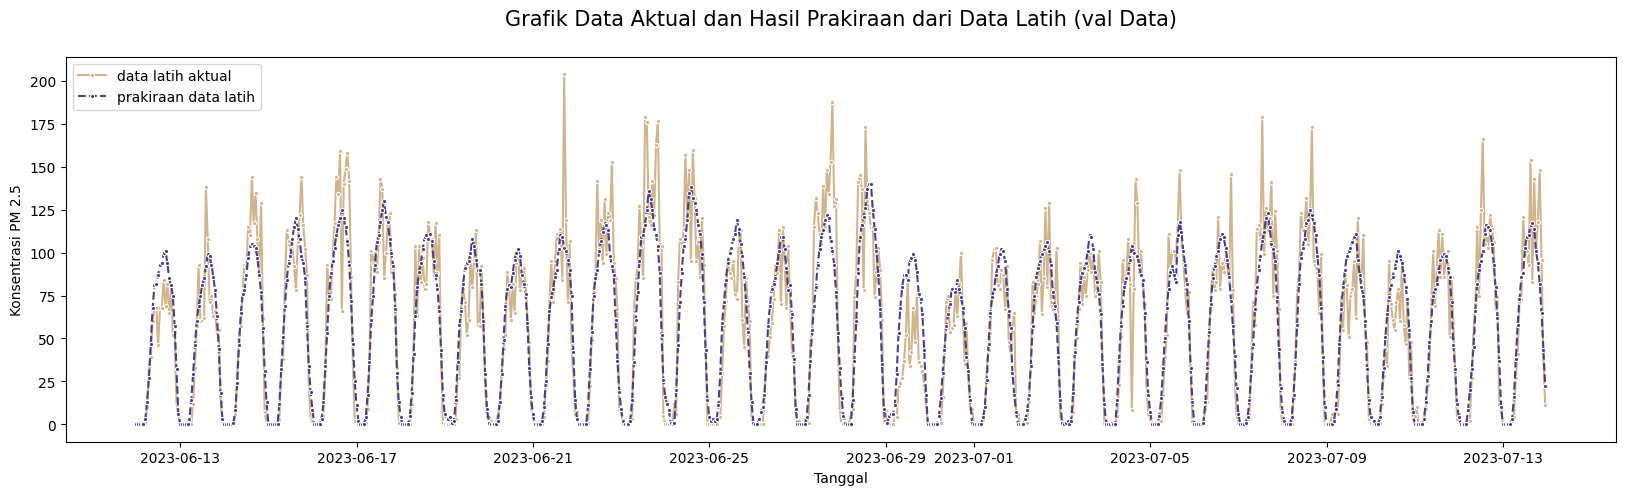

In [56]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T3", data=df_val, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T3", data=df_val, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (val Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [57]:
rmse = mean_squared_error(df_val['Forecast_T3'], df_val['Actual_T3'], squared=False)
mae = mean_absolute_error(df_val['Forecast_T3'], df_val['Actual_T3'])
mape = mean_absolute_percentage_error(df_val['Forecast_T3'], df_val['Actual_T3'])

print('Forecast val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast val accuracy
RMSE:  20.38
MAE:  13.91


### Prediction with testing data

In [58]:
forecast_test_data = model_forecast(modelVanillaLSTM, paxBMS_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(paxBMS_test_scaled.shape[0]-n_lookback)
forecast_test_data

121/121 [==============================] - 0s 3ms/step
(121, 24, 3)
(120, 3)
120


array([[-9.09545481e-01, -9.97192979e-01, -9.98628497e-01],
       [-1.04028642e+00, -1.13280904e+00, -1.12396991e+00],
       [-1.09199321e+00, -1.18731129e+00, -1.14056873e+00],
       [-1.11785841e+00, -1.20926619e+00, -1.14850616e+00],
       [-1.11614811e+00, -1.21600962e+00, -1.15415955e+00],
       [-1.00563097e+00, -1.12212873e+00, -1.10243607e+00],
       [-7.50257552e-01, -7.73149967e-01, -7.83921003e-01],
       [-3.31412882e-01, -1.60399005e-01, -2.59849519e-01],
       [ 1.23938277e-01,  5.22975326e-01,  2.48461798e-01],
       [ 5.28956771e-01,  9.54370379e-01,  5.97253561e-01],
       [ 6.95248544e-01,  8.99121106e-01,  7.53539324e-01],
       [ 8.38316381e-01,  7.88973331e-01,  1.01349449e+00],
       [ 1.07252550e+00,  8.49795580e-01,  1.23215830e+00],
       [ 1.19390297e+00,  8.83607805e-01,  1.38950217e+00],
       [ 1.22047257e+00,  9.78482604e-01,  1.52610040e+00],
       [ 1.20779681e+00,  1.12163854e+00,  1.54763079e+00],
       [ 9.72362101e-01,  1.05550659e+00

In [59]:
paxBMS_test[24:]

array([[  0,   0,   1],
       [  0,   0,   1],
       [  0,   0,   0],
       [  0,   0,   0],
       [  1,   0,   0],
       [  0,   9,   3],
       [  3,  23,   8],
       [ 36,  40,  27],
       [ 49,  75,  79],
       [ 69,  95,  71],
       [ 72,  83, 188],
       [ 70, 119, 111],
       [ 74,  95, 110],
       [ 35, 105, 132],
       [ 46,  85,  87],
       [ 61,  11,  20],
       [ 44, 110,  85],
       [ 72, 130, 148],
       [ 77, 133,  68],
       [ 33,  75,  82],
       [ 95, 138,  79],
       [ 16,  54,  46],
       [ 10,  52,  42],
       [  0,   0,   2],
       [  0,   6,   3],
       [  0,   6,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  1,   0,   0],
       [  3,  20,   0],
       [ 14,   7,   4],
       [ 14,  35,  42],
       [ 29,  55,  94],
       [ 75, 129,  79],
       [103,  98,  98],
       [ 63,  66, 102],
       [ 67,  84,  85],
       [ 93,  93,  77],
       [ 82,  53, 114],
       [ 98, 137, 136],
       [ 61, 125, 113],
       [ 82, 162

In [60]:
original = inverse_normalize_series(forecast_test_data, paxBMS_test)
original

array([[  6.,   8.,  10.],
       [  2.,   1.,   4.],
       [  1.,  -1.,   3.],
       [  0.,  -2.,   2.],
       [  0.,  -3.,   2.],
       [  3.,   2.,   5.],
       [ 11.,  20.,  20.],
       [ 24.,  51.,  45.],
       [ 38.,  85.,  70.],
       [ 50., 107.,  86.],
       [ 55., 104.,  94.],
       [ 59.,  99., 107.],
       [ 67., 102., 117.],
       [ 70., 103., 125.],
       [ 71., 108., 131.],
       [ 71., 115., 132.],
       [ 64., 112., 117.],
       [ 64., 122., 110.],
       [ 62., 124., 101.],
       [ 62., 125.,  94.],
       [ 47., 100.,  79.],
       [ 37.,  78.,  64.],
       [ 16.,  32.,  35.],
       [  4.,   7.,  10.],
       [  2.,  -1.,   1.],
       [  3.,   2.,  -2.],
       [  7.,   6.,  -3.],
       [  9.,   5.,   3.],
       [  9.,   4.,   6.],
       [ 10.,   8.,  10.],
       [ 14.,  19.,  23.],
       [ 23.,  42.,  43.],
       [ 34.,  72.,  62.],
       [ 44.,  91.,  76.],
       [ 57., 108.,  95.],
       [ 66., 113., 102.],
       [ 63., 101., 106.],
 

In [61]:
actual = np.squeeze(paxBMS_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(120, 3)
[[0 0 1]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [1 0 0]]


In [62]:
corrected_forecast = []
for i in original:
    temp = []
    for j in i:
        if j < 0:
            temp.append(0)
        elif j >= 0:
            _temp = np.ceil(j)
            temp.append(int(_temp))        
    corrected_forecast.append(temp)


corrected_forecast = np.array(corrected_forecast)
print(len(corrected_forecast))
corrected_forecast

120


array([[  6,   8,  10],
       [  2,   1,   4],
       [  1,   0,   3],
       [  0,   0,   2],
       [  0,   0,   2],
       [  3,   2,   5],
       [ 11,  20,  20],
       [ 24,  51,  45],
       [ 38,  85,  70],
       [ 50, 107,  86],
       [ 55, 104,  94],
       [ 59,  99, 107],
       [ 67, 102, 117],
       [ 70, 103, 125],
       [ 71, 108, 131],
       [ 71, 115, 132],
       [ 64, 112, 117],
       [ 64, 122, 110],
       [ 62, 124, 101],
       [ 62, 125,  94],
       [ 47, 100,  79],
       [ 37,  78,  64],
       [ 16,  32,  35],
       [  4,   7,  10],
       [  2,   0,   1],
       [  3,   2,   0],
       [  7,   6,   0],
       [  9,   5,   3],
       [  9,   4,   6],
       [ 10,   8,  10],
       [ 14,  19,  23],
       [ 23,  42,  43],
       [ 34,  72,  62],
       [ 44,  91,  76],
       [ 57, 108,  95],
       [ 66, 113, 102],
       [ 63, 101, 106],
       [ 59,  87, 106],
       [ 58,  79, 100],
       [ 57,  80,  96],
       [ 71, 119, 111],
       [ 75, 131

In [63]:
df_test = pd.DataFrame()
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index

df_test['Actual_T1'] = actual[:,0]
df_test['Actual_T2'] = actual[:,1]
df_test['Actual_T3'] = actual[:,2]

df_test['Forecast_T1'] = corrected_forecast[:,0]
df_test['Forecast_T2'] = corrected_forecast[:,1]
df_test['Forecast_T3'] = corrected_forecast[:,2]

df_test

Date  Actual_T1  Actual_T2  Actual_T3  Forecast_T1   
0   2023-07-15 00:00:00          0          0          1            6  \
1   2023-07-15 01:00:00          0          0          1            2   
2   2023-07-15 02:00:00          0          0          0            1   
3   2023-07-15 03:00:00          0          0          0            0   
4   2023-07-15 04:00:00          1          0          0            0   
..                  ...        ...        ...        ...          ...   
115 2023-07-19 19:00:00         73        119         65           43   
116 2023-07-19 20:00:00         69         92         90           34   
117 2023-07-19 21:00:00         28         25         47           28   
118 2023-07-19 22:00:00          2          9         31           13   
119 2023-07-19 23:00:00          1          3          4            4   

     Forecast_T2  Forecast_T3  
0              8           10  
1              1            4  
2              0            3  
3              0            2  
4              0            2  
..           ...          ...  
115           88           83  
116           71           69  
117           56           52  
118           25           25  
119            1            4  

[120 rows x 7 columns]

### Visualisasi testing data

#### Visualisasi T1

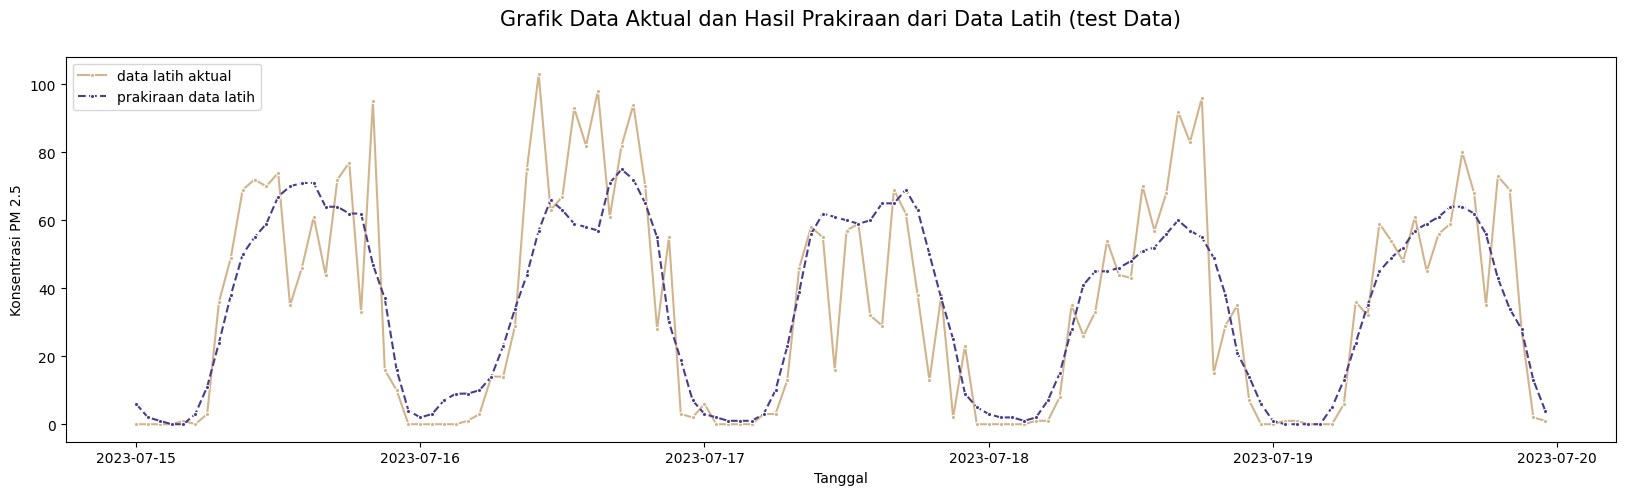

In [64]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T1", data=df_test, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T1", data=df_test, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [65]:
rmse = mean_squared_error(df_test['Forecast_T1'], df_test['Actual_T1'], squared=False)
mae = mean_absolute_error(df_test['Forecast_T1'], df_test['Actual_T1'])
mape = mean_absolute_percentage_error(df_test['Forecast_T1'], df_test['Actual_T1'])

print('Forecast test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast test accuracy
RMSE:  16.74
MAE:  11.82


#### Visualisasi T2

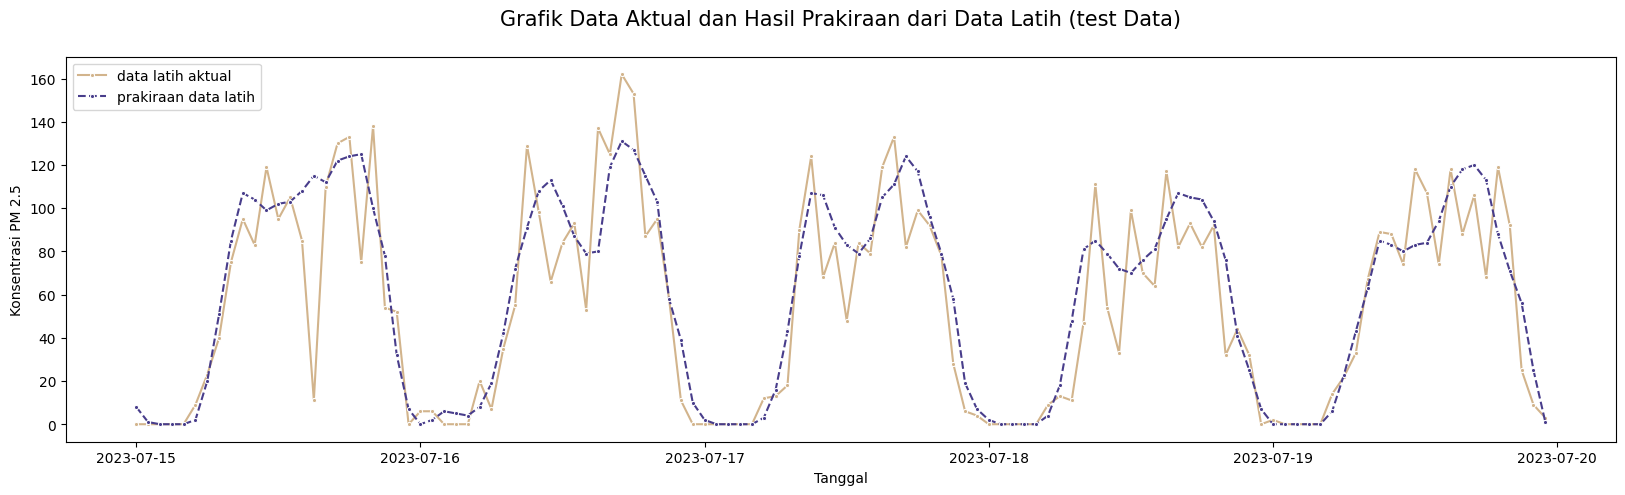

In [66]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T2", data=df_test, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T2", data=df_test, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [67]:
rmse = mean_squared_error(df_test['Forecast_T2'], df_test['Actual_T2'], squared=False)
mae = mean_absolute_error(df_test['Forecast_T2'], df_test['Actual_T2'])
mape = mean_absolute_percentage_error(df_test['Forecast_T2'], df_test['Actual_T2'])

print('Forecast test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast test accuracy
RMSE:  21.68
MAE:  14.92


#### Visualisasi T3

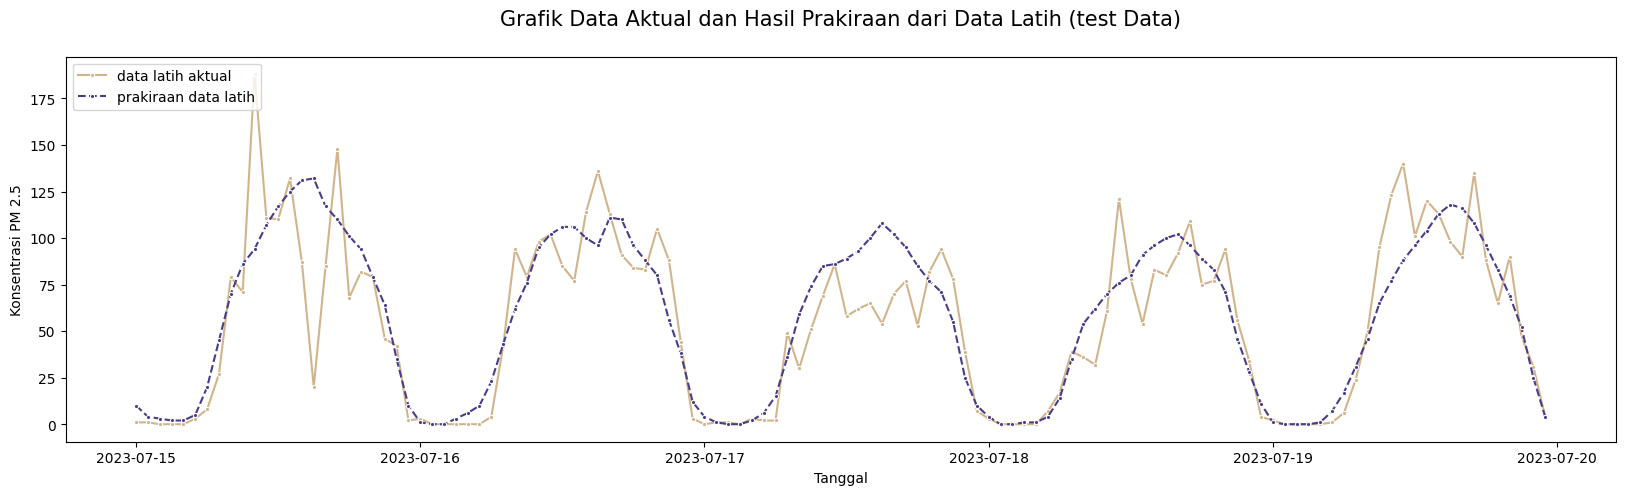

In [68]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T3", data=df_test, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T3", data=df_test, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [69]:
rmse = mean_squared_error(df_test['Forecast_T3'], df_test['Actual_T3'], squared=False)
mae = mean_absolute_error(df_test['Forecast_T3'], df_test['Actual_T3'])
mape = mean_absolute_percentage_error(df_test['Forecast_T3'], df_test['Actual_T3'])

print('Forecast test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast test accuracy
RMSE:  22.83
MAE:  14.79


# Bidirectional LSTM

## generate model

In [70]:
modelBiLSTM = Sequential([
        Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', return_sequences=True,
            ),input_shape=x_train[0].shape),                                   
        Flatten(),
        Dense(n_forecast * 3),
        Reshape([n_forecast, 3])
    ])

modelBiLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 24, 128)          34816     
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 72)                221256    
                                                                 
 reshape_1 (Reshape)         (None, 24, 3)             0         
                                                                 
Total params: 256,072
Trainable params: 256,072
Non-trainable params: 0
_________________________________________________________________


In [71]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
modelBiLSTM.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

In [72]:
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=15,verbose=1,
                                       restore_best_weights=True)
mc=tf.keras.callbacks.ModelCheckpoint('./model v3/BiLSTM-ModelAll.h5', monitor='val_mse', mode='min', verbose=1, save_best_only=True)

In [73]:
historyBiLSTM = modelBiLSTM.fit(
    x_train, y_train, 
    epochs=1000, 
    batch_size=32, 
    callbacks=[estop, mc],
    validation_data=(x_val,y_val))

Epoch 1/1000
50/52 [===========================>..] - ETA: 0s - loss: 3.1132 - mse: 0.9960
Epoch 1: val_mse improved from inf to 0.96065, saving model to ./model v3\BiLSTM-ModelAll.h5
52/52 [==============================] - 4s 31ms/step - loss: 3.1129 - mse: 0.9963 - val_loss: 3.0943 - val_mse: 0.9606
Epoch 2/1000
50/52 [===========================>..] - ETA: 0s - loss: 3.0717 - mse: 0.9423
Epoch 2: val_mse improved from 0.96065 to 0.90917, saving model to ./model v3\BiLSTM-ModelAll.h5
52/52 [==============================] - 1s 23ms/step - loss: 3.0720 - mse: 0.9447 - val_loss: 3.0532 - val_mse: 0.9092
Epoch 3/1000
51/52 [============================>.] - ETA: 0s - loss: 3.0322 - mse: 0.8953
Epoch 3: val_mse improved from 0.90917 to 0.85937, saving model to ./model v3\BiLSTM-ModelAll.h5
52/52 [==============================] - 1s 23ms/step - loss: 3.0320 - mse: 0.8951 - val_loss: 3.0129 - val_mse: 0.8594
Epoch 4/1000
50/52 [===========================>..] - ETA: 0s - loss: 2.9934 - m

In [74]:
with open('./model v3/historyBiLSTM', 'wb') as file_pi:
    pickle.dump(historyBiLSTM.history, file_pi)

with open('./model v3/historyBiLSTM', "rb") as file_pi:
    load_historyBiLSTM = pickle.load(file_pi)

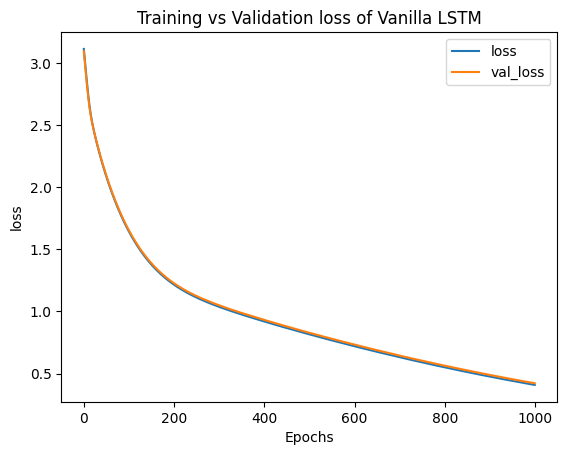

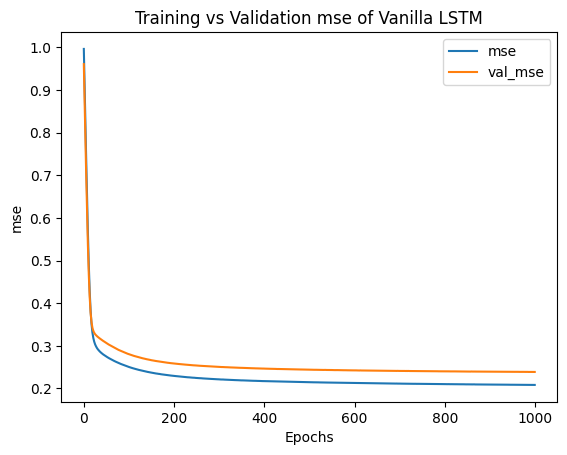

In [75]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric} of Vanilla LSTM")
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyBiLSTM, "loss")
plot_graphs(historyBiLSTM, "mse")

## Prediction

In [76]:
modelBiLSTM = tf.keras.models.load_model('./model v3/BiLSTM-ModelAll.h5')

### Prediction with training data

In [77]:
forecast_train_data = model_forecast(modelBiLSTM, paxBMS_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(paxBMS_train_scaled.shape[0]-n_lookback)
forecast_train_data

1681/1681 [==============================] - 12s 7ms/step
(1681, 24, 3)
(1680, 3)
1680


array([[-1.0252634 , -1.1337858 , -1.1878936 ],
       [-1.0229955 , -1.1797256 , -1.1664858 ],
       [-1.0179627 , -1.150099  , -1.0814646 ],
       ...,
       [-0.28499788, -0.00450771,  0.02123755],
       [-0.7905266 , -0.74025863, -0.687484  ],
       [-1.0195074 , -1.0403095 , -1.0513955 ]], dtype=float32)

In [78]:
paxBMS_train[24:]

array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       ...,
       [27, 62, 19],
       [ 5,  6, 28],
       [ 0,  3,  4]], dtype=int64)

In [79]:
original = inverse_normalize_series(forecast_train_data, paxBMS_train)
original

array([[-3., -4., -4.],
       [-3., -8., -3.],
       [-3., -5.,  1.],
       ...,
       [25., 80., 59.],
       [ 6., 25., 22.],
       [-3.,  3.,  3.]])

In [80]:
actual = np.squeeze(paxBMS_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1680, 3)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [81]:
corrected_forecast = []
for i in original:
    temp = []
    for j in i:
        if j < 0:
            temp.append(0)
        elif j >= 0:
            _temp = np.ceil(j)
            temp.append(int(_temp))        
    corrected_forecast.append(temp)


corrected_forecast = np.array(corrected_forecast)
print(len(corrected_forecast))
corrected_forecast

1680


array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  1],
       ...,
       [25, 80, 59],
       [ 6, 25, 22],
       [ 0,  3,  3]])

In [82]:
df_train = pd.DataFrame()
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index

df_train['Actual_T1'] = actual[:,0]
df_train['Actual_T2'] = actual[:,1]
df_train['Actual_T3'] = actual[:,2]

df_train['Forecast_T1'] = corrected_forecast[:,0]
df_train['Forecast_T2'] = corrected_forecast[:,1]
df_train['Forecast_T3'] = corrected_forecast[:,2]

df_train

Date  Actual_T1  Actual_T2  Actual_T3  Forecast_T1   
0    2023-04-02 00:00:00          0          0          0            0  \
1    2023-04-02 01:00:00          0          0          0            0   
2    2023-04-02 02:00:00          0          0          0            0   
3    2023-04-02 03:00:00          0          0          0            0   
4    2023-04-02 04:00:00          0          0          0            0   
...                  ...        ...        ...        ...          ...   
1675 2023-06-10 19:00:00         68        107         78           67   
1676 2023-06-10 20:00:00         22         68         76           49   
1677 2023-06-10 21:00:00         27         62         19           25   
1678 2023-06-10 22:00:00          5          6         28            6   
1679 2023-06-10 23:00:00          0          3          4            0   

      Forecast_T2  Forecast_T3  
0               0            0  
1               0            0  
2               0            1  
3               0            5  
4               3            7  
...           ...          ...  
1675          163          101  
1676          130           88  
1677           80           59  
1678           25           22  
1679            3            3  

[1680 rows x 7 columns]

### Visualisasi Training Data

#### Visualisasi T1

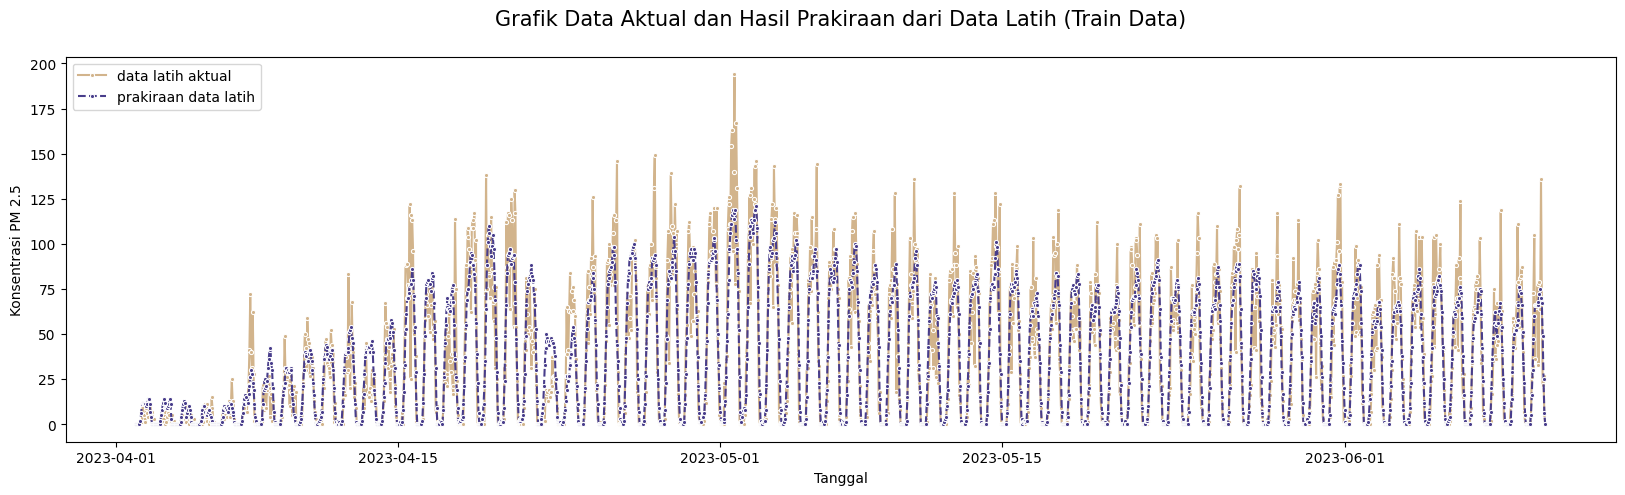

In [83]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T1", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T1", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [84]:
rmse = mean_squared_error(df_train['Forecast_T1'], df_train['Actual_T1'], squared=False)
mae = mean_absolute_error(df_train['Forecast_T1'], df_train['Actual_T1'])
mape = mean_absolute_percentage_error(df_train['Forecast_T1'], df_train['Actual_T1'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast Train accuracy
RMSE:  16.89
MAE:  10.82


#### Visualisasi T2

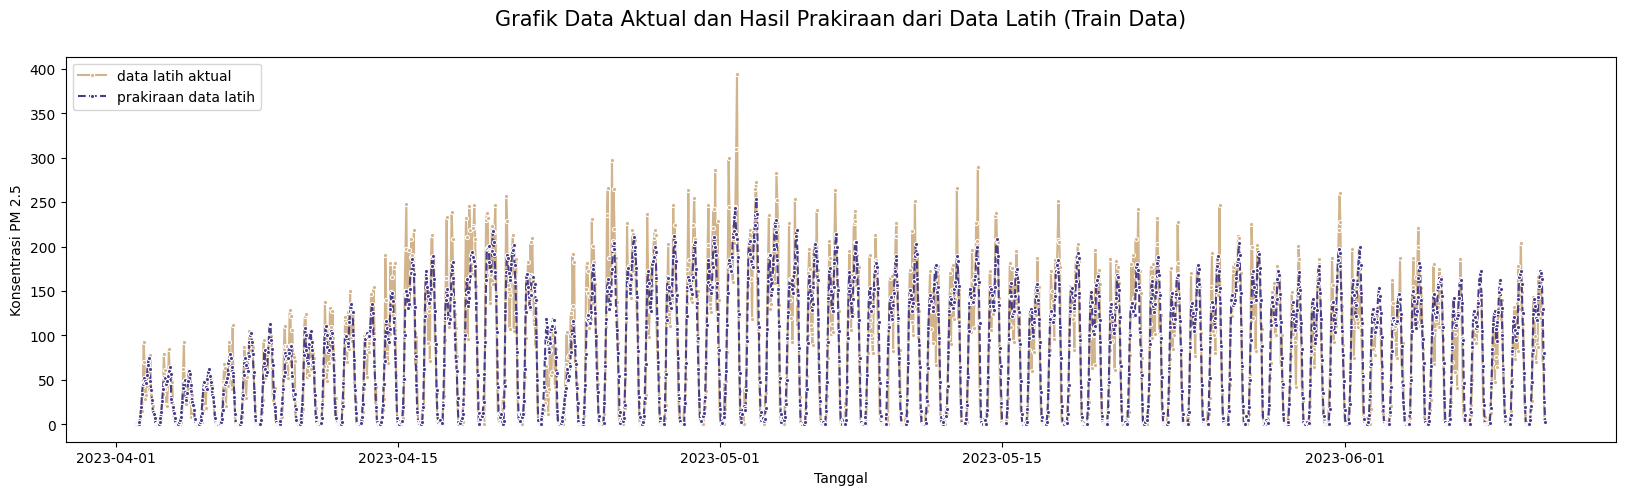

In [85]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T2", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T2", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [86]:
rmse = mean_squared_error(df_train['Forecast_T2'], df_train['Actual_T2'], squared=False)
mae = mean_absolute_error(df_train['Forecast_T2'], df_train['Actual_T2'])
mape = mean_absolute_percentage_error(df_train['Forecast_T2'], df_train['Actual_T2'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast Train accuracy
RMSE:  27.97
MAE:  18.95


#### Visualisasi T3

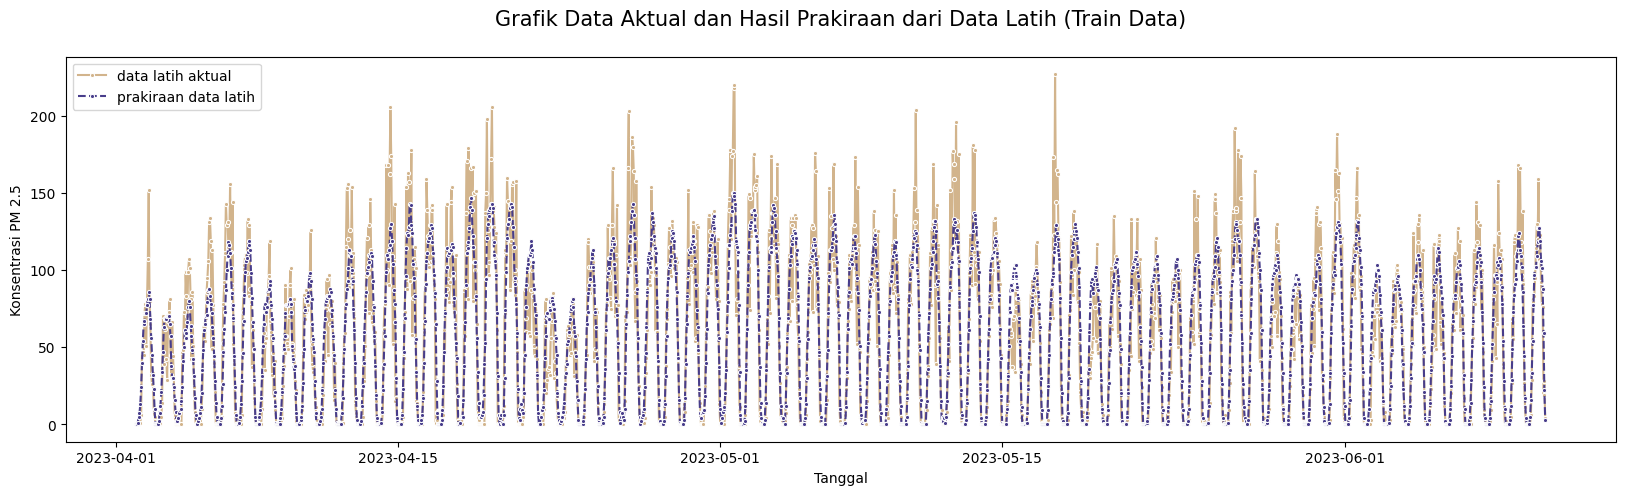

In [87]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T3", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T3", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [88]:
rmse = mean_squared_error(df_train['Forecast_T3'], df_train['Actual_T3'], squared=False)
mae = mean_absolute_error(df_train['Forecast_T3'], df_train['Actual_T3'])
mape = mean_absolute_percentage_error(df_train['Forecast_T3'], df_train['Actual_T3'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast Train accuracy
RMSE:  22.18
MAE:  15.09


### Prediction with validation data

In [89]:
forecast_val_data = model_forecast(modelBiLSTM, paxBMS_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(paxBMS_val_scaled.shape[0]-n_lookback)
forecast_val_data

769/769 [==============================] - 3s 3ms/step
(769, 24, 3)
(768, 3)
768


array([[-1.1521124 , -1.2860355 , -1.1962267 ],
       [-1.17319   , -1.3668867 , -1.3103441 ],
       [-1.0981904 , -1.2695187 , -1.2633483 ],
       ...,
       [ 0.00682175,  0.18046963,  0.31676555],
       [-0.35185173, -0.25176814, -0.16137964],
       [-0.8282113 , -0.84295017, -0.7291308 ]], dtype=float32)

In [90]:
paxBMS_val[24:]

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       ...,
       [ 28, 102,  96],
       [  9,  19,  39],
       [  1,   0,  11]], dtype=int64)

In [91]:
original = inverse_normalize_series(forecast_val_data, paxBMS_val)
original

array([[ -2.,  -6.,  -1.],
       [ -3., -11.,  -7.],
       [ -0.,  -5.,  -4.],
       ...,
       [ 36.,  77.,  72.],
       [ 24.,  53.,  49.],
       [  9.,  19.,  21.]])

In [92]:
actual = np.squeeze(paxBMS_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(768, 3)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [93]:
corrected_forecast = []
for i in original:
    temp = []
    for j in i:
        if j < 0:
            temp.append(0)
        elif j >= 0:
            _temp = np.ceil(j)
            temp.append(int(_temp))        
    corrected_forecast.append(temp)


corrected_forecast = np.array(corrected_forecast)
print(len(corrected_forecast))
corrected_forecast

768


array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       ...,
       [36, 77, 72],
       [24, 53, 49],
       [ 9, 19, 21]])

In [94]:
df_val = pd.DataFrame()
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index

df_val['Actual_T1'] = actual[:,0]
df_val['Actual_T2'] = actual[:,1]
df_val['Actual_T3'] = actual[:,2]

df_val['Forecast_T1'] = corrected_forecast[:,0]
df_val['Forecast_T2'] = corrected_forecast[:,1]
df_val['Forecast_T3'] = corrected_forecast[:,2]

df_val

Date  Actual_T1  Actual_T2  Actual_T3  Forecast_T1   
0   2023-06-12 00:00:00          0          0          0            0  \
1   2023-06-12 01:00:00          0          0          0            0   
2   2023-06-12 02:00:00          0          0          0            0   
3   2023-06-12 03:00:00          0          0          0            2   
4   2023-06-12 04:00:00          0          0          0            4   
..                  ...        ...        ...        ...          ...   
763 2023-07-13 19:00:00         49        137        118           64   
764 2023-07-13 20:00:00         71        149        148           47   
765 2023-07-13 21:00:00         28        102         96           36   
766 2023-07-13 22:00:00          9         19         39           24   
767 2023-07-13 23:00:00          1          0         11            9   

     Forecast_T2  Forecast_T3  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              3            2  
..           ...          ...  
763          130           94  
764          101           83  
765           77           72  
766           53           49  
767           19           21  

[768 rows x 7 columns]

### Visualisasi validation data

#### Visualisasi T1

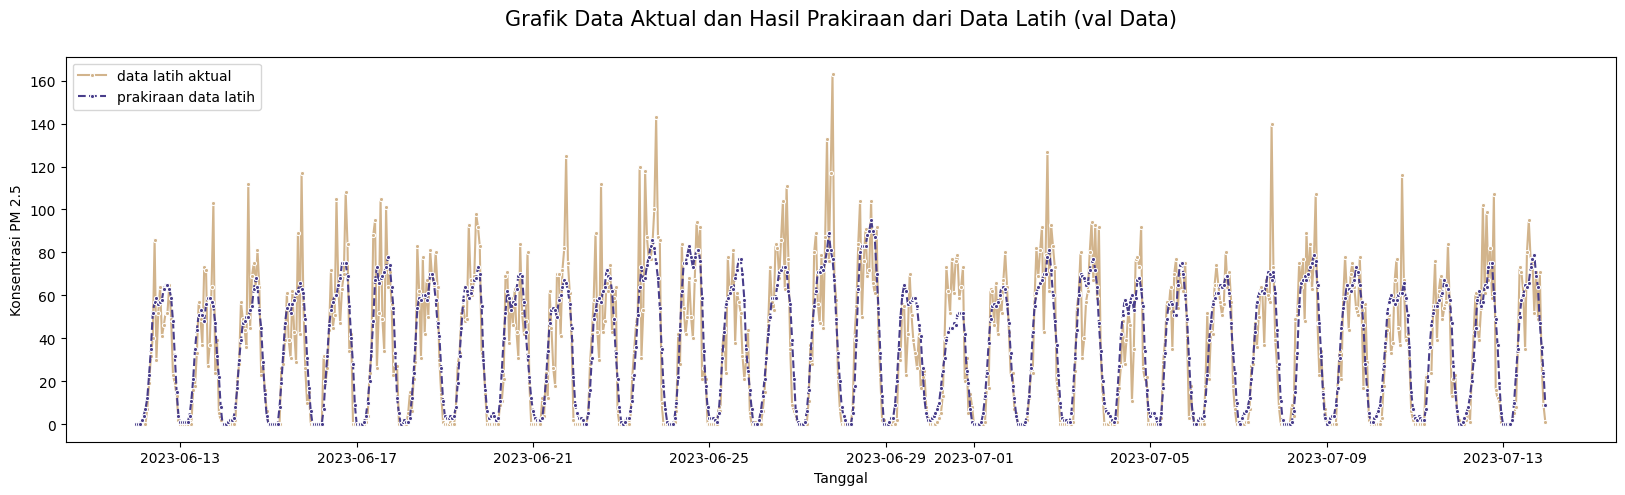

In [95]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T1", data=df_val, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T1", data=df_val, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (val Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [96]:
rmse = mean_squared_error(df_val['Forecast_T1'], df_val['Actual_T1'], squared=False)
mae = mean_absolute_error(df_val['Forecast_T1'], df_val['Actual_T1'])
mape = mean_absolute_percentage_error(df_val['Forecast_T1'], df_val['Actual_T1'])

print('Forecast val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast val accuracy
RMSE:  16.62
MAE:  11.61


#### Visualisasi T2

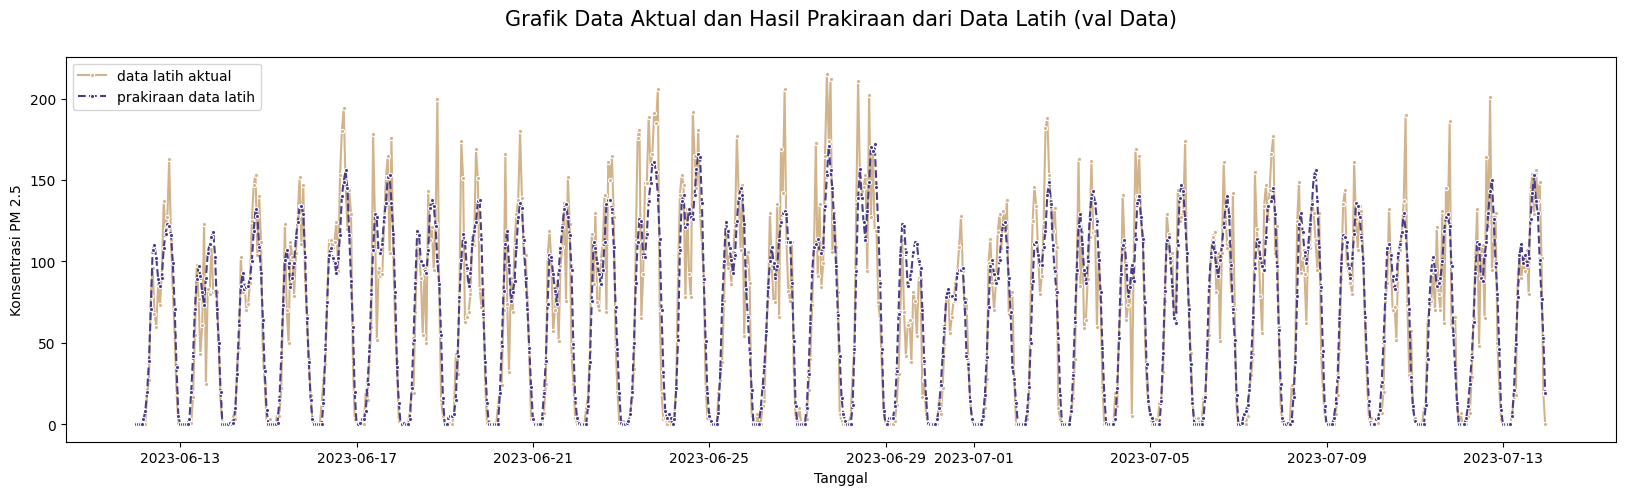

In [97]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T2", data=df_val, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T2", data=df_val, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (val Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [98]:
rmse = mean_squared_error(df_val['Forecast_T2'], df_val['Actual_T2'], squared=False)
mae = mean_absolute_error(df_val['Forecast_T2'], df_val['Actual_T2'])
mape = mean_absolute_percentage_error(df_val['Forecast_T2'], df_val['Actual_T2'])

print('Forecast val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast val accuracy
RMSE:  24.13
MAE:  16.7


#### Visualisasi T3

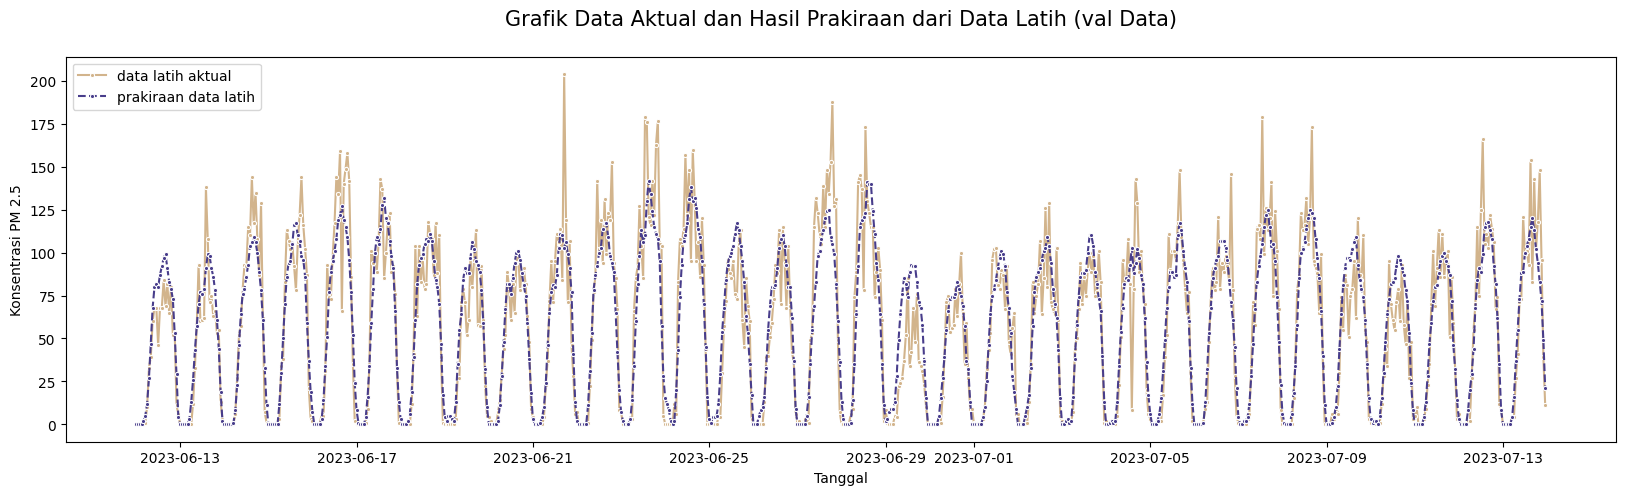

In [99]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T3", data=df_val, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T3", data=df_val, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (val Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [100]:
rmse = mean_squared_error(df_val['Forecast_T3'], df_val['Actual_T3'], squared=False)
mae = mean_absolute_error(df_val['Forecast_T3'], df_val['Actual_T3'])
mape = mean_absolute_percentage_error(df_val['Forecast_T3'], df_val['Actual_T3'])

print('Forecast val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast val accuracy
RMSE:  19.83
MAE:  13.55


### Prediction with testing data

In [101]:
forecast_test_data = model_forecast(modelBiLSTM, paxBMS_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(paxBMS_test_scaled.shape[0]-n_lookback)
forecast_test_data

121/121 [==============================] - 0s 4ms/step
(121, 24, 3)
(120, 3)
120


array([[-0.99407434, -1.0917332 , -1.0507531 ],
       [-1.0923411 , -1.2084653 , -1.1642911 ],
       [-1.1165824 , -1.1867204 , -1.1443633 ],
       [-1.1179422 , -1.1977841 , -1.1232424 ],
       [-1.1039956 , -1.1948107 , -1.1149852 ],
       [-0.9997272 , -1.0909499 , -1.0592186 ],
       [-0.7656197 , -0.77223796, -0.7838439 ],
       [-0.36241668, -0.21149068, -0.31365913],
       [ 0.08152522,  0.475991  ,  0.19852337],
       [ 0.5596035 ,  1.006862  ,  0.62703925],
       [ 0.7585196 ,  0.9853613 ,  0.78752196],
       [ 0.90898776,  0.8692141 ,  1.0901656 ],
       [ 1.120517  ,  0.85497224,  1.2420206 ],
       [ 1.2060829 ,  0.84501797,  1.3608658 ],
       [ 1.20715   ,  0.90992665,  1.5144    ],
       [ 1.1383636 ,  1.0477229 ,  1.5046967 ],
       [ 0.82176924,  0.85571593,  1.030965  ],
       [ 0.91280115,  1.2009157 ,  0.9981776 ],
       [ 0.9701568 ,  1.3750594 ,  0.9464857 ],
       [ 0.92096525,  1.347948  ,  0.735906  ],
       [ 0.383313  ,  0.7617632 ,  0.350

In [102]:
paxBMS_test[24:]

array([[  0,   0,   1],
       [  0,   0,   1],
       [  0,   0,   0],
       [  0,   0,   0],
       [  1,   0,   0],
       [  0,   9,   3],
       [  3,  23,   8],
       [ 36,  40,  27],
       [ 49,  75,  79],
       [ 69,  95,  71],
       [ 72,  83, 188],
       [ 70, 119, 111],
       [ 74,  95, 110],
       [ 35, 105, 132],
       [ 46,  85,  87],
       [ 61,  11,  20],
       [ 44, 110,  85],
       [ 72, 130, 148],
       [ 77, 133,  68],
       [ 33,  75,  82],
       [ 95, 138,  79],
       [ 16,  54,  46],
       [ 10,  52,  42],
       [  0,   0,   2],
       [  0,   6,   3],
       [  0,   6,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  1,   0,   0],
       [  3,  20,   0],
       [ 14,   7,   4],
       [ 14,  35,  42],
       [ 29,  55,  94],
       [ 75, 129,  79],
       [103,  98,  98],
       [ 63,  66, 102],
       [ 67,  84,  85],
       [ 93,  93,  77],
       [ 82,  53, 114],
       [ 98, 137, 136],
       [ 61, 125, 113],
       [ 82, 162

In [103]:
original = inverse_normalize_series(forecast_test_data, paxBMS_test)
original

array([[  4.,   3.,   7.],
       [  1.,  -2.,   2.],
       [  0.,  -1.,   3.],
       [  0.,  -2.,   4.],
       [  0.,  -2.,   4.],
       [  4.,   3.,   7.],
       [ 11.,  20.,  20.],
       [ 23.,  48.,  43.],
       [ 36.,  83.,  67.],
       [ 51., 110.,  88.],
       [ 57., 108.,  96.],
       [ 62., 103., 110.],
       [ 68., 102., 118.],
       [ 71., 101., 123.],
       [ 71., 105., 131.],
       [ 69., 112., 130.],
       [ 59., 102., 107.],
       [ 62., 119., 106.],
       [ 63., 128., 103.],
       [ 62., 127.,  93.],
       [ 46.,  97.,  75.],
       [ 39.,  80.,  65.],
       [ 14.,  31.,  33.],
       [  4.,   6.,  11.],
       [  0.,  -5.,   1.],
       [  2.,  -0.,  -1.],
       [  7.,   7.,  -0.],
       [ 10.,   8.,   4.],
       [  9.,   5.,   7.],
       [  9.,   7.,  11.],
       [ 13.,  18.,  21.],
       [ 21.,  39.,  39.],
       [ 32.,  68.,  58.],
       [ 45.,  94.,  77.],
       [ 60., 115.,  98.],
       [ 67., 116., 103.],
       [ 63.,  99., 103.],
 

In [104]:
actual = np.squeeze(paxBMS_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(120, 3)
[[0 0 1]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [1 0 0]]


In [105]:
corrected_forecast = []
for i in original:
    temp = []
    for j in i:
        if j < 0:
            temp.append(0)
        elif j >= 0:
            _temp = np.ceil(j)
            temp.append(int(_temp))        
    corrected_forecast.append(temp)


corrected_forecast = np.array(corrected_forecast)
print(len(corrected_forecast))
corrected_forecast

120


array([[  4,   3,   7],
       [  1,   0,   2],
       [  0,   0,   3],
       [  0,   0,   4],
       [  0,   0,   4],
       [  4,   3,   7],
       [ 11,  20,  20],
       [ 23,  48,  43],
       [ 36,  83,  67],
       [ 51, 110,  88],
       [ 57, 108,  96],
       [ 62, 103, 110],
       [ 68, 102, 118],
       [ 71, 101, 123],
       [ 71, 105, 131],
       [ 69, 112, 130],
       [ 59, 102, 107],
       [ 62, 119, 106],
       [ 63, 128, 103],
       [ 62, 127,  93],
       [ 46,  97,  75],
       [ 39,  80,  65],
       [ 14,  31,  33],
       [  4,   6,  11],
       [  0,   0,   1],
       [  2,   0,   0],
       [  7,   7,   0],
       [ 10,   8,   4],
       [  9,   5,   7],
       [  9,   7,  11],
       [ 13,  18,  21],
       [ 21,  39,  39],
       [ 32,  68,  58],
       [ 45,  94,  77],
       [ 60, 115,  98],
       [ 67, 116, 103],
       [ 63,  99, 103],
       [ 59,  84, 102],
       [ 59,  80, 100],
       [ 59,  85,  99],
       [ 75, 123, 116],
       [ 75, 131

In [106]:
df_test = pd.DataFrame()
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index

df_test['Actual_T1'] = actual[:,0]
df_test['Actual_T2'] = actual[:,1]
df_test['Actual_T3'] = actual[:,2]

df_test['Forecast_T1'] = corrected_forecast[:,0]
df_test['Forecast_T2'] = corrected_forecast[:,1]
df_test['Forecast_T3'] = corrected_forecast[:,2]

df_test

Date  Actual_T1  Actual_T2  Actual_T3  Forecast_T1   
0   2023-07-15 00:00:00          0          0          1            4  \
1   2023-07-15 01:00:00          0          0          1            1   
2   2023-07-15 02:00:00          0          0          0            0   
3   2023-07-15 03:00:00          0          0          0            0   
4   2023-07-15 04:00:00          1          0          0            0   
..                  ...        ...        ...        ...          ...   
115 2023-07-19 19:00:00         73        119         65           42   
116 2023-07-19 20:00:00         69         92         90           36   
117 2023-07-19 21:00:00         28         25         47           30   
118 2023-07-19 22:00:00          2          9         31           13   
119 2023-07-19 23:00:00          1          3          4            2   

     Forecast_T2  Forecast_T3  
0              3            7  
1              0            2  
2              0            3  
3              0            4  
4              0            4  
..           ...          ...  
115           87           81  
116           74           70  
117           61           56  
118           25           25  
119            0            3  

[120 rows x 7 columns]

In [107]:
# total_actualT1 = df_test[df_test['Date'] >= '2023-07-19']['Actual_T1'].sum()
# print(total_actualT1)

# total_forecastT1 = df_test[df_test['Date'] >= '2023-07-19']['Forecast_T1'].sum()
# print(total_forecastT1)

# print('selisih =', total_actualT1-total_forecastT1)
# print(((total_actualT1-total_forecastT1)/total_forecastT1) * 100, '%')

### Visualisasi testing data

#### Visualisasi T1

In [108]:
total_actualT1 = df_test['Actual_T1'].sum()
print(total_actualT1)

total_forecastT1 = df_test['Forecast_T1'].sum()
print(total_forecastT1)

print('selisih =', total_actualT1-total_forecastT1)
print(((total_actualT1-total_forecastT1)/total_forecastT1) * 100, '%')

4133
4114
selisih = 19
0.46183762761302866 %


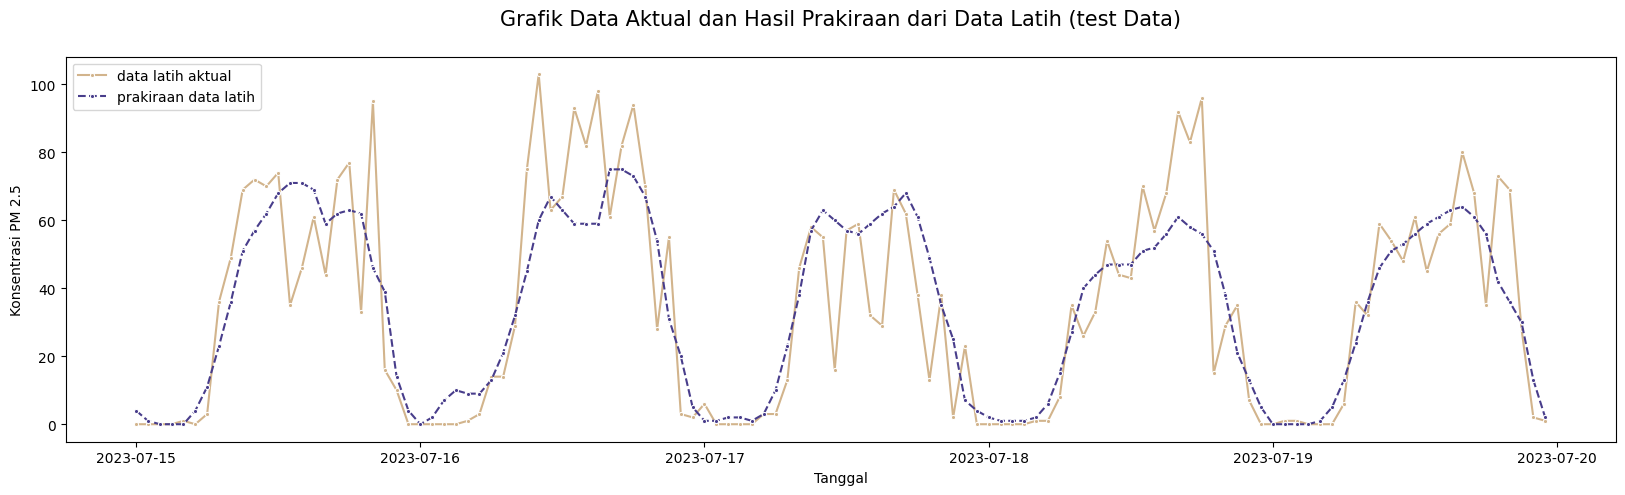

In [109]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T1", data=df_test, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T1", data=df_test, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [110]:
rmse = mean_squared_error(df_test['Forecast_T1'], df_test['Actual_T1'], squared=False)
mae = mean_absolute_error(df_test['Forecast_T1'], df_test['Actual_T1'])
mape = mean_absolute_percentage_error(df_test['Forecast_T1'], df_test['Actual_T1'])

print('Forecast test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast test accuracy
RMSE:  16.39
MAE:  11.51


#### Visualisasi T2

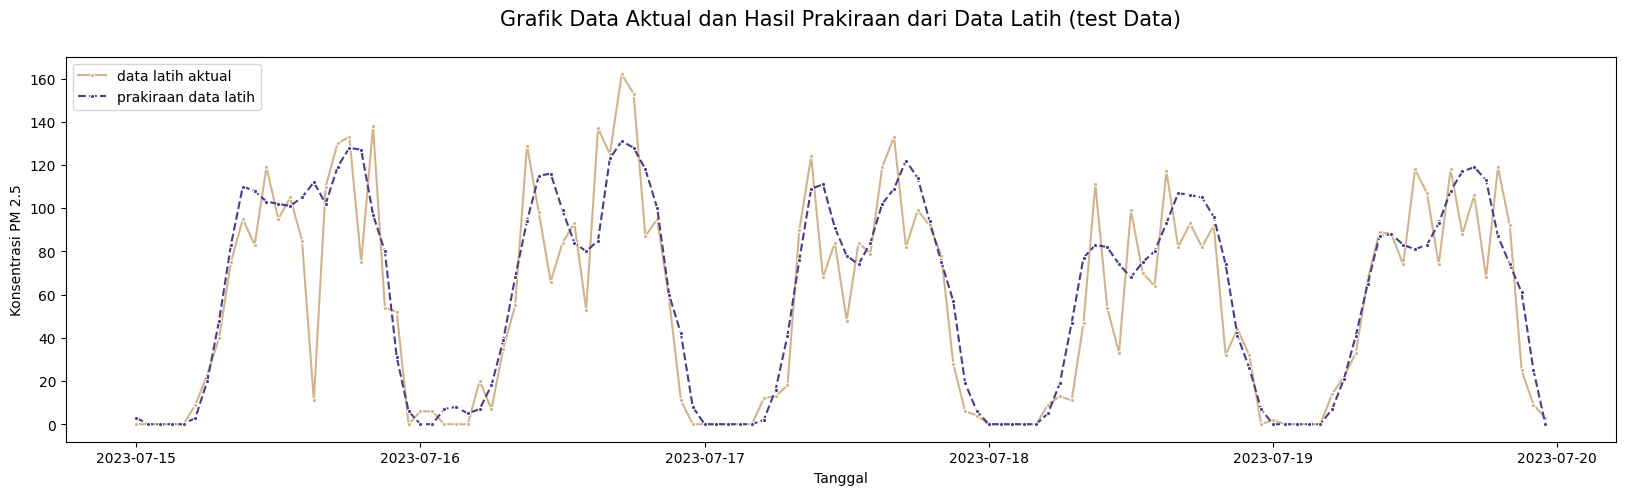

In [111]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T2", data=df_test, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T2", data=df_test, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [112]:
rmse = mean_squared_error(df_test['Forecast_T2'], df_test['Actual_T2'], squared=False)
mae = mean_absolute_error(df_test['Forecast_T2'], df_test['Actual_T2'])
mape = mean_absolute_percentage_error(df_test['Forecast_T2'], df_test['Actual_T2'])

print('Forecast test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast test accuracy
RMSE:  21.7
MAE:  14.91


#### Visualisasi T3

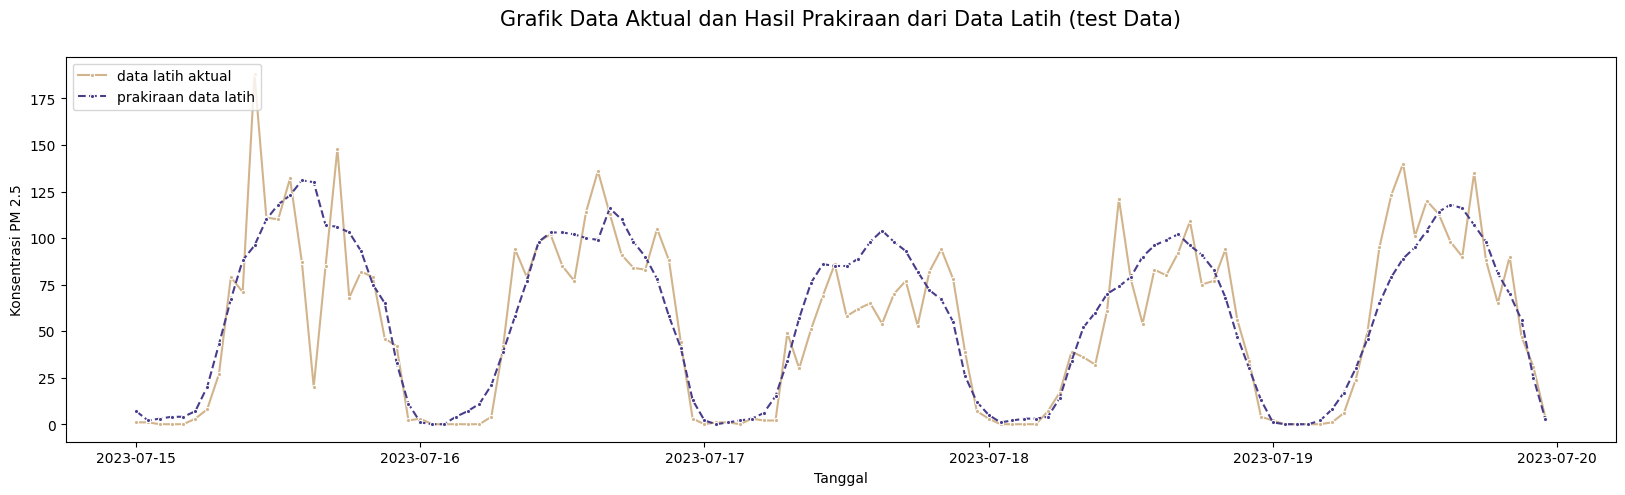

In [113]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T3", data=df_test, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T3", data=df_test, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [114]:
rmse = mean_squared_error(df_test['Forecast_T3'], df_test['Actual_T3'], squared=False)
mae = mean_absolute_error(df_test['Forecast_T3'], df_test['Actual_T3'])
mape = mean_absolute_percentage_error(df_test['Forecast_T3'], df_test['Actual_T3'])

print('Forecast test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast test accuracy
RMSE:  22.4
MAE:  14.82
